In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict

idx = pd.IndexSlice

In [2]:
results = pd.read_csv(
    Path.cwd().parent /
    'summaries' /
    'total_summary.csv',
    index_col=[0,1],
    parse_dates=True
    )

C:\Users\lukas\AppData\Local\Temp\ipykernel_20948\3647985580.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results = pd.read_csv(


In [16]:
total_costs = {}

def stack_to_ax(df, ax):

    s = df.sum()

    total_costs[s.name] = s.sum()
    x_loc = '{}-{}'.format(df.index[0][0], df.index[0][1])

    pos = s.loc[s > 0]
    neg = s.loc[s < 0]

    pos_quants = [q for q in list(nice_names) if q in pos.index]
    neg_quants = [q for q in list(nice_names) if q in neg.index]

    pos = pos.loc[pos_quants]
    pos_bottom = [0] + pos.cumsum().tolist()[:-1]

    for (name, value), b in zip(pos.items(), pos_bottom):

        ax.bar(
            x_loc,
            bottom=b,
            height=value,
            label=nice_names[name],
            color=color_dict[name]
            )

    neg = neg.loc[neg_quants]
    neg_bottom = [0] + neg.cumsum().tolist()[:-1]

    for (name, value), b in zip(neg.items(), neg_bottom):
        # assert len(neg) == 1
        ax.bar(
            x_loc,
            bottom=0,
            height=value,
            label=nice_names[name],
            color=color_dict[name]
            )

    ax.text(
        x_loc, pos.sum() + 0.2,
        '{}'.format(np.around(s.sum(), decimals=1)),
        ha='center',
    )

    ax.scatter([x_loc], [s.sum()], color='w', zorder=10, edgecolor='k', s=50)

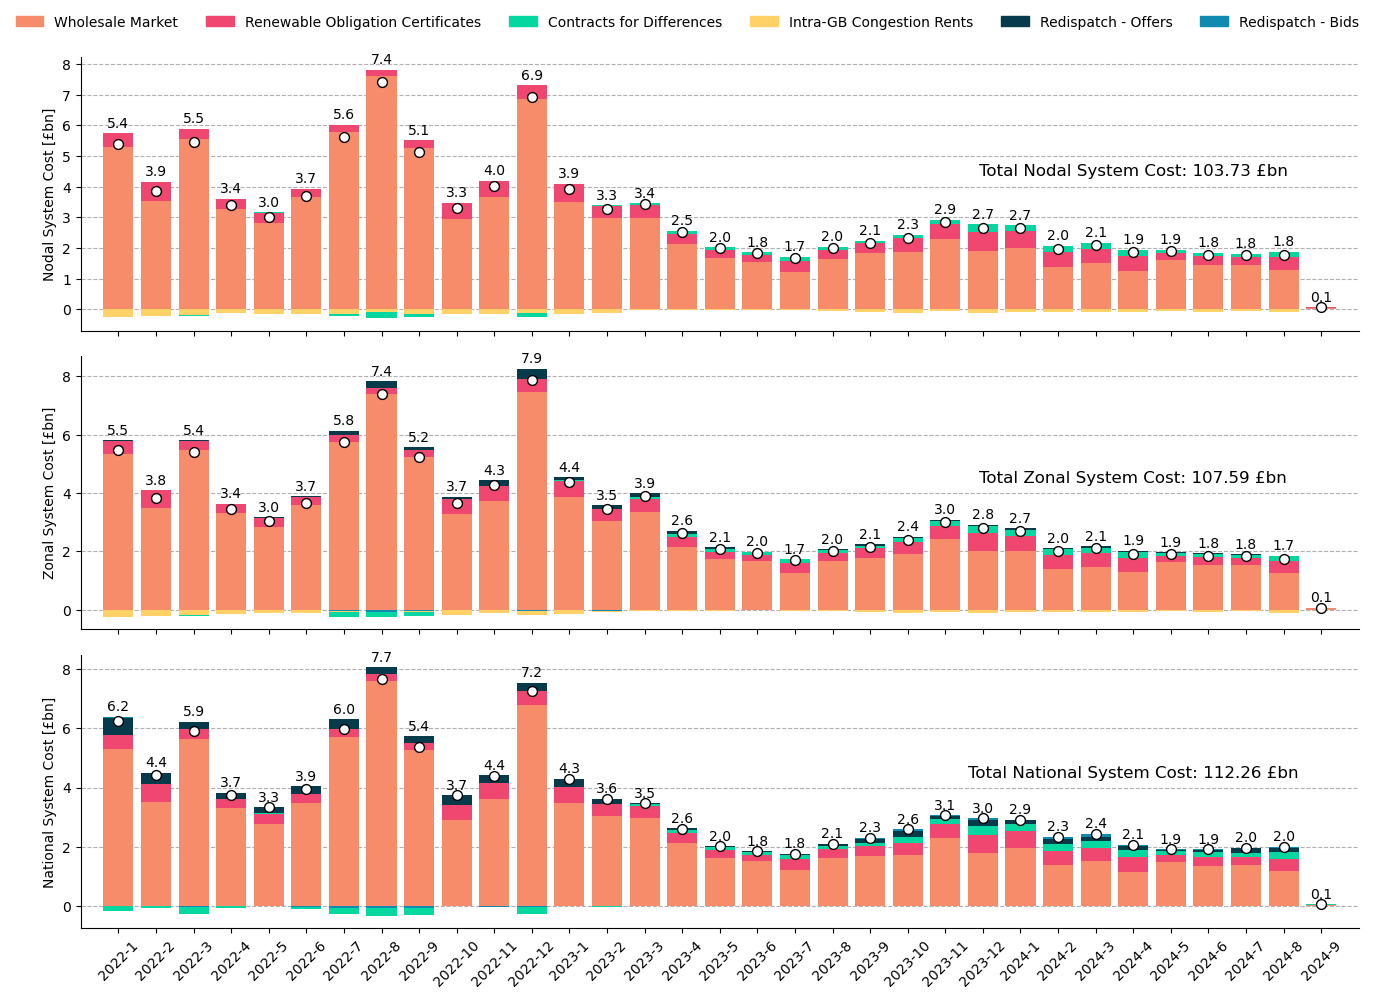

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for col, ax in zip(results.columns, axs):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'{col.capitalize()} System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    ax.text(
        len(df) - 6, 4.5,
        f'Total {col.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    bbox_to_anchor=(1.01, 1.2),
    frameon=False,
    ncol=6
    )

plt.tight_layout()
plt.show()

In [21]:
nquants = len(results.index.get_level_values(1).unique())

total_date_range = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m'),
    results.index.get_level_values(0).max().strftime('%Y-%m'),
    freq='ME').strftime('%Y-%m')

total_hh = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m-%d'),
    results.index.get_level_values(0).max().strftime('%Y-%m-%d'),
    freq='30min')

missing_share = pd.Series(np.nan, total_date_range)

for m in total_date_range:

    n_modelled = len(results.loc[idx[m, :], :]) / nquants
    n_total = pd.date_range(m, pd.Timestamp(m) + pd.offsets.MonthEnd(1), freq='30min')

    missing_share[m] = 1 - n_modelled / len(n_total)